In [1]:
import torch                                 
import torch.nn as nn                          
import torch.nn.functional as F                 
import numpy as np                              
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy

%matplotlib inline

In [2]:
BATCH_SIZE = 1                              
LR = 0.001                   # learning rate
N_ACTIONS = 1                # action dim
N_STATES = 1                 # state dim
episode = 300           
dim = 1            
T = 1                        # time
N = 100                      # number of time interval
dt = T / N
discount = 1                 
seed = 10
number = 1                  
MEMORY_CAPACITY = N * number
sigma = 1
TAU = 0.1                    # hyperparameter of DDPG
initial_point = torch.tensor([0.0])
terminal_point = torch.tensor([2.0])                    
plt.rc('font', family='serif')
fontdict_prop = {'family': 'serif', 'size': 20}

In [3]:
# the equation that evolution follows
def propagate(x, u):
    
    delta_x = drift(x, u) * dt

    return x + delta_x

# drift term of SDE
def drift(x, u):

    return - x + u
    
# divergence of drift
def derivative(state):
    
    dx = -1
    
    return dx
    
def reward(x, u):     

    return (torch.square(u) / sigma ** 2 + derivative(x)) * dt

# terminal prediction
def terminal_loss1(x, actor, index):
    
    s = x
    y = terminal_point
    for i in range(N - index):
        a = actor(s)
        s_ = propagate(s, a)
        s = s_

    loss = nn.L1Loss()(s.reshape(-1), y)
    
    return loss

# true solution of SDE 
def true_plot(initial_point, terminal_point, T, t):
    
    a = initial_point
    b = terminal_point
    
    return (b * np.e ** T - a) * np.e ** t/ (np.e**(T * 2) - 1)  + (a * np.e**(T * 2) - b * np.e ** T) * np.e ** (-t) / (np.e ** (T * 2) - 1)

In [4]:
# neural network for actor
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 15)
        self.linear2 = nn.Linear(15, self.action_size)
        self.action_bound = 20
        
    def forward(self, state):

        output = self.linear1(state)
        output = F.relu(output)
        output = self.linear2(output)
        output = torch.tanh(output) * self.action_bound
        
        return output

# neural network for critic 
class Critic(nn.Module):
    def __init__(self, state_size, value_size):
        
        super(Critic, self).__init__()
        self.state_size = state_size
        self.linear1 = nn.Linear(self.state_size, 15)
        self.linear2 = nn.Linear(15, value_size)

    def forward(self, state):

        output = self.linear1(state)
        output = torch.arctan(output)
        output = self.linear2(output)
        
        return output

In [5]:
# Actor-Critic class
class AC(object):
    def __init__(self):                                                         
        self.actor = Actor(N_STATES, N_ACTIONS)
        self.actor_target = Actor(N_STATES, N_ACTIONS)
        self.critic = Critic(N_ACTIONS + N_STATES, 1)
        self.critic_target = Critic(N_ACTIONS + N_STATES, 1)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.memory_counter = 0                                                 
        self.memory = torch.zeros((MEMORY_CAPACITY, 4))                           
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=LR)    
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=LR)

    def store_transition(self, s, a, r, s_):                                    
        transition = torch.cat((s.detach(), a.detach(), r.detach(), s_.detach()))  
        index = self.memory_counter % MEMORY_CAPACITY                          
        self.memory[index, :] = transition                                      
        self.memory_counter += 1                                               

    def learn(self, notion):                                   
        tra = []
        for i in range(N):
            tra.append(self.memory[[N*j+i for j in range(number)]])
        sample_index = np.random.choice(number, BATCH_SIZE)                    
        b_memory = tra[notion][sample_index, :]                                
        b_s = b_memory[:, :N_STATES]                  
        b_a = b_memory[:, N_STATES:N_STATES+1]
        b_r = b_memory[:, N_STATES+1:N_STATES+2]
        b_s_ = b_memory[:, -N_STATES:]

        Q_cur = self.critic(torch.cat((b_s, b_a), 1))
        if notion == N-1:
            Q_next = torch.tensor(0., requires_grad=True)
        else:
            Q_next = self.critic_target(torch.cat((b_s_, self.actor_target(b_s_)), 1))
        td_error = b_r + discount * Q_next - Q_cur
        critic_loss = torch.mean(torch.square(td_error)) * 10000 * sigma ** 2

        if notion == N-1:
            for j in range(4):
                self.optimizer_critic.zero_grad()
                critic_loss.backward(retain_graph=True)
                self.optimizer_critic.step()
                Q_cur = self.critic(torch.cat((b_s, b_a), 1))
                Q_next = torch.tensor(0., requires_grad=True)
                td_error = b_r + discount * Q_next - Q_cur
                critic_loss = torch.mean(torch.square(td_error)) * 10000

        else:
            for j in range(2):
                self.optimizer_critic.zero_grad()
                critic_loss.backward(retain_graph=True)
                self.optimizer_critic.step()
                Q_cur = self.critic(torch.cat((b_s, b_a), 1))
                Q_next = self.critic_target(torch.cat((b_s_, self.actor_target(b_s_)), 1))
                td_error = b_r + discount * Q_next - Q_cur
                critic_loss = torch.mean(torch.square(td_error)) * 10000
        
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()
        
        Q_cur = self.critic(torch.cat((b_s, self.actor(b_s)), 1))
        actor_loss_ = torch.mean(Q_cur) * 0.5
        terminal_loss = terminal_loss1(b_s, self.actor, notion) * 10
        actor_loss = actor_loss_ + terminal_loss
        
        for j in range(1):
            self.optimizer_actor.zero_grad()
            actor_loss.backward()
            self.optimizer_actor.step()
            Q_cur = self.critic(torch.cat((b_s, self.actor(b_s)), 1))
            actor_loss_ = torch.mean(Q_cur) * 0.5
            terminal_loss = terminal_loss1(b_s, self.actor, notion) * 100
            actor_loss = actor_loss_ + terminal_loss
            
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
            
        self.soft_update(self.critic, self.critic_target, TAU)
        self.soft_update(self.actor, self.actor_target, TAU)   
        
        return critic_loss.detach().numpy(), actor_loss.detach().numpy(), actor_loss_.detach().numpy(), terminal_loss.detach().numpy()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0-tau) * target_param.data)

In [6]:
torch.manual_seed(seed)
ac = AC()   
line = []
total_reward = []
loss_critic = []
loss_actor = []
loss_terminal = []

In [7]:
start_time = time.time()
for i in range(episode):                                                   
    print('<<<<<<<<<Episode: %s' % i)
    s = initial_point
    episode_reward_sum = 0                                       #initialize total reward

    for j in range(N): 

        a = ac.actor(s)
        a = torch.normal(a, 0.01)
        s_ = propagate(s, a)
        r = reward(s, a)

        ac.store_transition(s, a, r.reshape(-1), s_)             # store samples
        episode_reward_sum += r.detach().numpy()                 # cumulate reward

        s = s_                                               

        if ac.memory_counter > MEMORY_CAPACITY:            
            critic_loss, actor_loss, actor_loss_, terminal_loss = ac.learn(j)
            
            loss_critic.append(np.around(critic_loss, 2))
            loss_actor.append(np.around(actor_loss, 2))
            loss_terminal.append(np.around(terminal_loss, 2))
            
        else:
            critic_loss = 0
            actor_loss = 0
            actor_loss_ = 0
            terminal_loss = 0

        if j == N - 1:       
            print('episode: %s --- reward_sum: %s --- critic_loss: %s --- actor_loss: %s --- actor_loss_: %s --- terminal_loss: %s' 
                  % (i, np.around(episode_reward_sum, 2),  np.around(critic_loss, 2), np.around(actor_loss, 2), np.around(actor_loss_, 2)
                    , np.around(terminal_loss, 2)))
            print(round(time.time() - start_time, 2))
    data = pd.DataFrame(ac.memory.detach().numpy())
    line.append(copy.deepcopy(data))
    total_reward.append(np.around(episode_reward_sum, 2))

<<<<<<<<<Episode: 0
episode: 0 --- reward_sum: [14.86] --- critic_loss: 0 --- actor_loss: 0 --- actor_loss_: 0 --- terminal_loss: 0
0.01
<<<<<<<<<Episode: 1
episode: 1 --- reward_sum: [9.07] --- critic_loss: 23285.62 --- actor_loss: 0.82 --- actor_loss_: 0.78 --- terminal_loss: 0.04
1.44
<<<<<<<<<Episode: 2
episode: 2 --- reward_sum: [9.04] --- critic_loss: 30475.99 --- actor_loss: 0.91 --- actor_loss_: 0.89 --- terminal_loss: 0.02
2.86
<<<<<<<<<Episode: 3
episode: 3 --- reward_sum: [9.05] --- critic_loss: 39039.11 --- actor_loss: 1.02 --- actor_loss_: 1.0 --- terminal_loss: 0.01
4.29
<<<<<<<<<Episode: 4
episode: 4 --- reward_sum: [9.05] --- critic_loss: 46971.51 --- actor_loss: 1.11 --- actor_loss_: 1.09 --- terminal_loss: 0.02
5.71
<<<<<<<<<Episode: 5
episode: 5 --- reward_sum: [9.05] --- critic_loss: 52797.24 --- actor_loss: 1.17 --- actor_loss_: 1.16 --- terminal_loss: 0.01
7.14
<<<<<<<<<Episode: 6
episode: 6 --- reward_sum: [9.06] --- critic_loss: 54060.18 --- actor_loss: 1.21 ---

episode: 54 --- reward_sum: [8.28] --- critic_loss: 21.8 --- actor_loss: 0.22 --- actor_loss_: 0.09 --- terminal_loss: 0.14
77.17
<<<<<<<<<Episode: 55
episode: 55 --- reward_sum: [8.27] --- critic_loss: 256.08 --- actor_loss: 0.2 --- actor_loss_: 0.08 --- terminal_loss: 0.12
78.6
<<<<<<<<<Episode: 56
episode: 56 --- reward_sum: [8.28] --- critic_loss: 44.46 --- actor_loss: 0.1 --- actor_loss_: 0.08 --- terminal_loss: 0.02
80.03
<<<<<<<<<Episode: 57
episode: 57 --- reward_sum: [8.27] --- critic_loss: 230.16 --- actor_loss: 0.08 --- actor_loss_: 0.08 --- terminal_loss: 0.0
81.45
<<<<<<<<<Episode: 58
episode: 58 --- reward_sum: [8.25] --- critic_loss: 49.86 --- actor_loss: 0.26 --- actor_loss_: 0.09 --- terminal_loss: 0.17
82.88
<<<<<<<<<Episode: 59
episode: 59 --- reward_sum: [8.25] --- critic_loss: 221.04 --- actor_loss: 0.2 --- actor_loss_: 0.11 --- terminal_loss: 0.09
84.3
<<<<<<<<<Episode: 60
episode: 60 --- reward_sum: [8.26] --- critic_loss: 16.03 --- actor_loss: 0.11 --- actor_los

episode: 108 --- reward_sum: [8.21] --- critic_loss: 1.61 --- actor_loss: 0.13 --- actor_loss_: 0.13 --- terminal_loss: 0.0
154.52
<<<<<<<<<Episode: 109
episode: 109 --- reward_sum: [8.2] --- critic_loss: 106.33 --- actor_loss: 0.16 --- actor_loss_: 0.1 --- terminal_loss: 0.06
155.96
<<<<<<<<<Episode: 110
episode: 110 --- reward_sum: [8.21] --- critic_loss: 13.4 --- actor_loss: 0.14 --- actor_loss_: 0.12 --- terminal_loss: 0.02
157.39
<<<<<<<<<Episode: 111
episode: 111 --- reward_sum: [8.21] --- critic_loss: 159.66 --- actor_loss: 0.16 --- actor_loss_: 0.1 --- terminal_loss: 0.06
158.82
<<<<<<<<<Episode: 112
episode: 112 --- reward_sum: [8.2] --- critic_loss: 16.65 --- actor_loss: 0.17 --- actor_loss_: 0.12 --- terminal_loss: 0.05
160.25
<<<<<<<<<Episode: 113
episode: 113 --- reward_sum: [8.21] --- critic_loss: 326.19 --- actor_loss: 0.12 --- actor_loss_: 0.12 --- terminal_loss: 0.0
161.68
<<<<<<<<<Episode: 114
episode: 114 --- reward_sum: [8.2] --- critic_loss: 60.73 --- actor_loss: 0

episode: 162 --- reward_sum: [8.2] --- critic_loss: 6.66 --- actor_loss: 0.16 --- actor_loss_: 0.12 --- terminal_loss: 0.04
231.8
<<<<<<<<<Episode: 163
episode: 163 --- reward_sum: [8.2] --- critic_loss: 150.12 --- actor_loss: 0.12 --- actor_loss_: 0.11 --- terminal_loss: 0.01
233.23
<<<<<<<<<Episode: 164
episode: 164 --- reward_sum: [8.21] --- critic_loss: 9.45 --- actor_loss: 0.18 --- actor_loss_: 0.12 --- terminal_loss: 0.06
234.66
<<<<<<<<<Episode: 165
episode: 165 --- reward_sum: [8.21] --- critic_loss: 162.42 --- actor_loss: 0.24 --- actor_loss_: 0.11 --- terminal_loss: 0.13
236.09
<<<<<<<<<Episode: 166
episode: 166 --- reward_sum: [8.19] --- critic_loss: 21.18 --- actor_loss: 0.23 --- actor_loss_: 0.11 --- terminal_loss: 0.11
237.52
<<<<<<<<<Episode: 167
episode: 167 --- reward_sum: [8.21] --- critic_loss: 198.65 --- actor_loss: 0.2 --- actor_loss_: 0.12 --- terminal_loss: 0.08
238.95
<<<<<<<<<Episode: 168
episode: 168 --- reward_sum: [8.2] --- critic_loss: 4.74 --- actor_loss: 

episode: 216 --- reward_sum: [8.19] --- critic_loss: 15.15 --- actor_loss: 0.16 --- actor_loss_: 0.12 --- terminal_loss: 0.04
309.07
<<<<<<<<<Episode: 217
episode: 217 --- reward_sum: [8.19] --- critic_loss: 198.56 --- actor_loss: 0.21 --- actor_loss_: 0.12 --- terminal_loss: 0.09
310.5
<<<<<<<<<Episode: 218
episode: 218 --- reward_sum: [8.2] --- critic_loss: 23.36 --- actor_loss: 0.13 --- actor_loss_: 0.11 --- terminal_loss: 0.02
311.93
<<<<<<<<<Episode: 219
episode: 219 --- reward_sum: [8.21] --- critic_loss: 94.46 --- actor_loss: 0.17 --- actor_loss_: 0.1 --- terminal_loss: 0.08
313.36
<<<<<<<<<Episode: 220
episode: 220 --- reward_sum: [8.2] --- critic_loss: 4.56 --- actor_loss: 0.13 --- actor_loss_: 0.12 --- terminal_loss: 0.01
314.79
<<<<<<<<<Episode: 221
episode: 221 --- reward_sum: [8.2] --- critic_loss: 71.96 --- actor_loss: 0.11 --- actor_loss_: 0.09 --- terminal_loss: 0.02
316.22
<<<<<<<<<Episode: 222
episode: 222 --- reward_sum: [8.2] --- critic_loss: 6.79 --- actor_loss: 0.

episode: 270 --- reward_sum: [8.21] --- critic_loss: 22.84 --- actor_loss: 0.1 --- actor_loss_: 0.1 --- terminal_loss: 0.0
386.32
<<<<<<<<<Episode: 271
episode: 271 --- reward_sum: [8.21] --- critic_loss: 98.19 --- actor_loss: 0.12 --- actor_loss_: 0.09 --- terminal_loss: 0.03
387.75
<<<<<<<<<Episode: 272
episode: 272 --- reward_sum: [8.21] --- critic_loss: 5.7 --- actor_loss: 0.1 --- actor_loss_: 0.1 --- terminal_loss: 0.0
389.18
<<<<<<<<<Episode: 273
episode: 273 --- reward_sum: [8.21] --- critic_loss: 75.44 --- actor_loss: 0.1 --- actor_loss_: 0.08 --- terminal_loss: 0.02
390.61
<<<<<<<<<Episode: 274
episode: 274 --- reward_sum: [8.22] --- critic_loss: 7.37 --- actor_loss: 0.12 --- actor_loss_: 0.1 --- terminal_loss: 0.02
392.04
<<<<<<<<<Episode: 275
episode: 275 --- reward_sum: [8.21] --- critic_loss: 74.34 --- actor_loss: 0.09 --- actor_loss_: 0.08 --- terminal_loss: 0.0
393.47
<<<<<<<<<Episode: 276
episode: 276 --- reward_sum: [8.21] --- critic_loss: 7.86 --- actor_loss: 0.11 ---

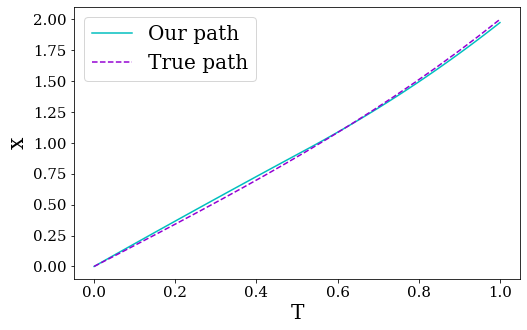

In [19]:
x = np.linspace(0, T, 20)
start = 100
end = 299
dd = line[start].copy(deep=True)
for num in range(start + 1, end + 1):
    dd += line[num] 
data = dd / (end - start + 1)        # average data
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, T, N), data.loc[:, 0], color='c', label='Our path')
plt.plot(x, true_plot(initial_point, terminal_point, T, x), color='darkviolet', linestyle='--', label='True path')
plt.xlabel('T', fontsize=20)
plt.ylabel('x', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop=fontdict_prop)
plt.savefig('0 to 2 plot.png', bbox_inches='tight', dpi=150)
plt.show()

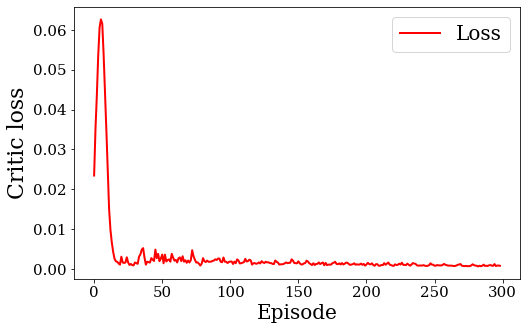

In [9]:
loss_mean = np.mean(np.array(loss_critic).reshape(-1, N), 1)/10000
plt.figure(figsize=(8, 5))
plt.plot(loss_mean, color='r', label='Loss', linewidth=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Critic loss', fontsize=22)
# plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.legend(prop=fontdict_prop)
plt.savefig('0 to 2 loss_critic.png', bbox_inches='tight', dpi=150)
plt.show()

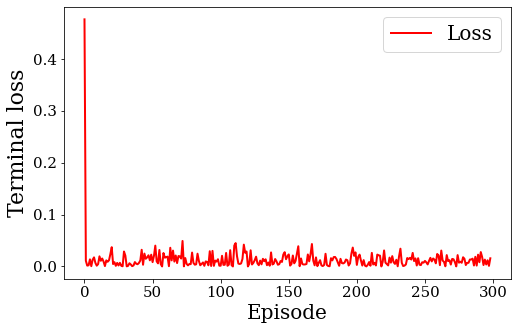

In [10]:
temp = np.array(loss_terminal).reshape(-1, N)
aa = []
for i in range(temp.shape[0]):
    aa.append(temp[i, 0])
ter = np.array(aa)/100
plt.figure(figsize=(8, 5))
plt.plot(range(len(aa)), ter, color='r', label='Loss', linewidth=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Terminal loss', fontsize=22)
plt.legend(prop=fontdict_prop)
plt.savefig('0 to 2 loss_terminal.png', bbox_inches='tight', dpi=150)
plt.show()

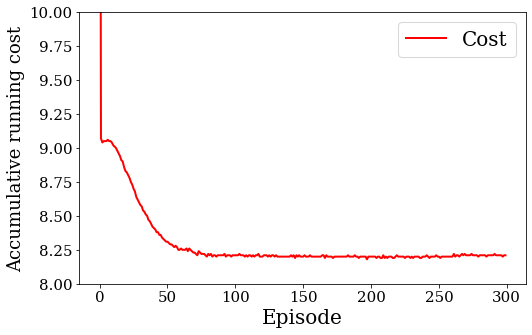

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(total_reward[:], color='r', label='Cost', linewidth=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Accumulative running cost', fontsize=18)
plt.ylim(8,10)
plt.legend(prop=fontdict_prop)
plt.savefig('0 to 2 cost.png', bbox_inches='tight', dpi=150)
plt.show()